# The best performing model so far on asl100

In [1]:
import torch
import test
from configs import Config
from torchvision.transforms import v2
from video_dataset import VideoDataset
import os
from torch.utils.data import DataLoader
from models.pytorch_r3d import Resnet3D18_basic
import json
import utils

2025-08-04 17:23:03.963382: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-08-04 17:23:03.973218: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-08-04 17:23:03.985069: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-08-04 17:23:03.988405: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-08-04 17:23:03.997529: I tensorflow/core/platform/cpu_feature_guar

In [2]:
torch.manual_seed(42)
model = 'r3d18'
split = 'asl100'
exp_no = '10'.zfill(3)


root = '../data/WLASL2000'
labels=f'./preprocessed/labels/{split}'
output=f'runs/{split}/{model}_exp{exp_no}'
config_path = f'./configfiles/{split}/{model}_{exp_no}.ini'
model_dict='best.pth'
classes_path = './wlasl_class_list.json'
label_suffix='_fixed_frange_bboxes_len.json'
title = f'''Testting {model} on split {split} 
              Experiment no: {exp_no} 
              Raw videos at: {root}
              Labels at: {labels}
              Saving files to: {output}
              Model weights: {model_dict}
              \n
          '''
print(title)

Testting r3d18 on split asl100 
              Experiment no: 010 
              Raw videos at: ../data/WLASL2000
              Labels at: ./preprocessed/labels/asl100
              Saving files to: runs/asl100/r3d18_exp010
              Model weights: best.pth
              

          


In [3]:

test.run_test_r3d18_1(root=root,
                      output=output,
                      labels=labels,
                      model_dict=model_dict,
                      save=True)

/home/luke/ExtraStorage/WLASL/lukes-code/test.py:74: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  r3d18_dict = torch.load(os.path.join(output,'checkpoints', model_dict)) #f

Using device: cuda


Testing: 100%|██████████| 258/258 [00:27<00:00,  9.39it/s]

top-k average per class acc: 0.648, 0.8633333333333333, 0.9208333333333333
Overall top1 (sklearn style) 0.6356589147286822


In [4]:
#setup transforms
base_mean = [0.43216, 0.394666, 0.37645]
base_std = [0.22803, 0.22145, 0.216989]

r3d18_final = v2.Compose([
  v2.Lambda(lambda x: x.float() / 255.0),
  # v2.Lambda(lambda x: vt.normalise(x, base_mean, base_std)),
  v2.Normalize(mean=base_mean, std=base_std),
  v2.Lambda(lambda x: x.permute(1,0,2,3)) 
])

test_transforms = v2.Compose([v2.CenterCrop(224),
                              r3d18_final])


#setup data
test_instances = os.path.join(labels, 'test_instances_fixed_frange_bboxes_len.json')
test_classes = os.path.join(labels, 'test_classes_fixed_frange_bboxes_len.json')

test_set = VideoDataset(root, test_instances, test_classes,
                        transforms=test_transforms, num_frames=32)
test_loader = DataLoader(test_set, batch_size=1,shuffle=False,
                          num_workers=0)
num_classes = len(set(test_set.classes))
# print(num_classes)

In [5]:
#setup model
r3d18 = Resnet3D18_basic(num_classes=num_classes)
r3d18_dict = torch.load(os.path.join(output,'checkpoints', model_dict), weights_only=True) #future warning, use weights_only=True (security stuff if you dont know the file)
# print(r3d18_dict)
r3d18.load_state_dict(r3d18_dict)
r3d18.cuda()
r3d18.eval()

Resnet3D18_basic(
  (backbone): Sequential(
    (0): BasicStem(
      (0): Conv3d(3, 64, kernel_size=(3, 7, 7), stride=(1, 2, 2), padding=(1, 3, 3), bias=False)
      (1): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): BasicBlock(
        (conv1): Sequential(
          (0): Conv3DSimple(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
          (1): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
        )
        (conv2): Sequential(
          (0): Conv3DSimple(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
          (1): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (relu): ReLU(inplace=True)
      )
      (1): BasicBlock(
        (conv1): Sequential(
          (0): Conv3DSimple(64, 64, kernel_size=(3, 3, 

In [6]:
accuracy, class_report, all_preds, all_targets = test.test_model(r3d18, test_loader)
print(f'Accuracy score: {accuracy}')

Testing: 100%|██████████| 258/258 [00:26<00:00,  9.59it/s]

Accuracy score: 0.6356589147286822


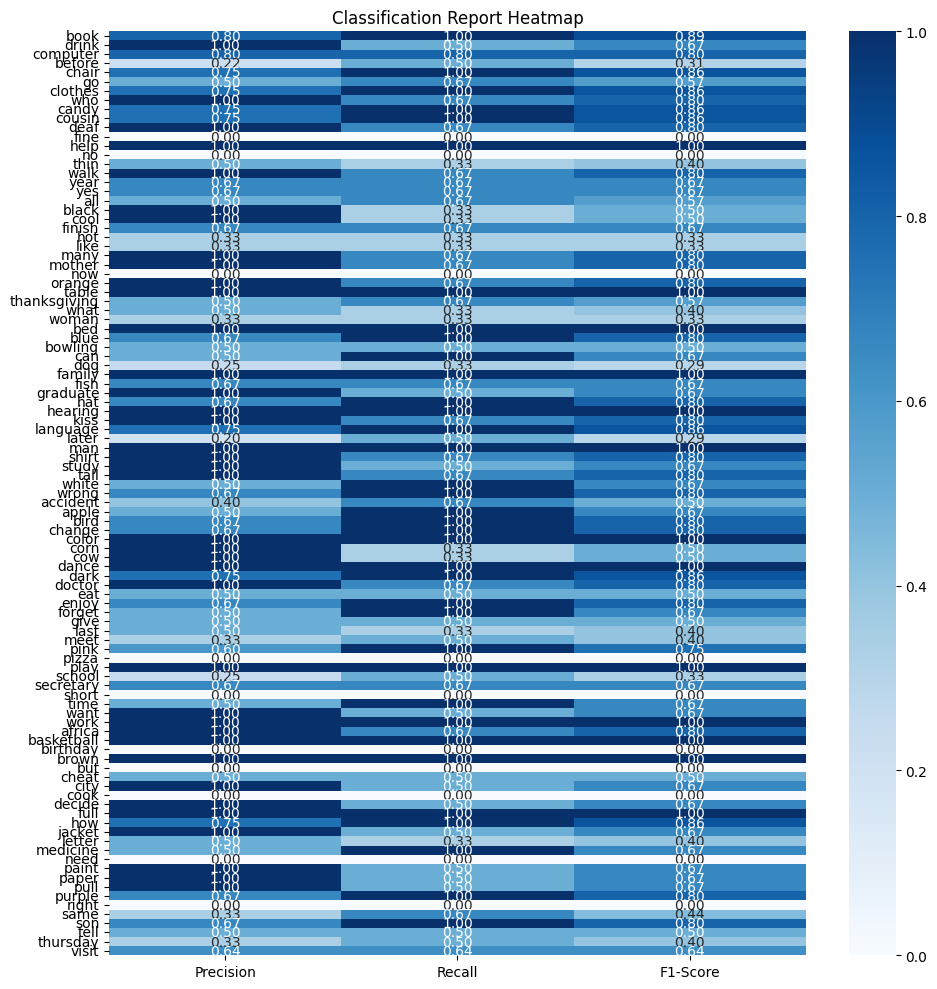

In [7]:
test.plot_heatmap(class_report, classes_path)

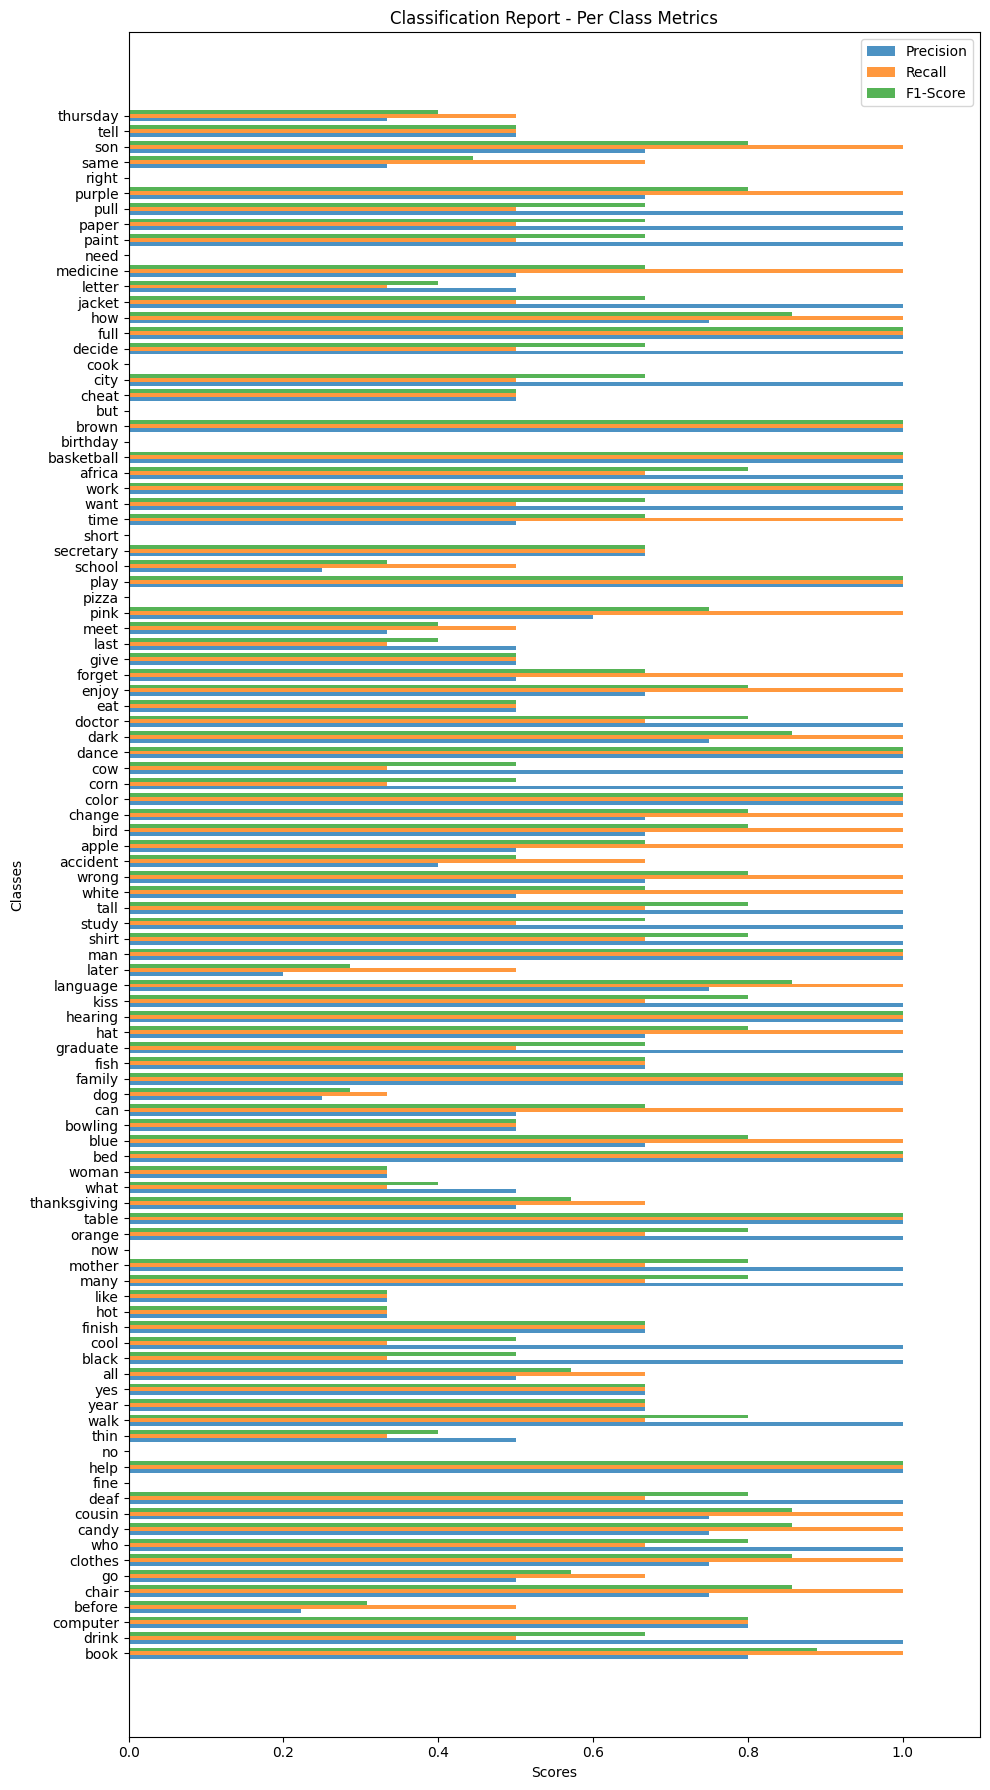

In [8]:
test.plot_bar_graph(class_report, classes_path)

In [32]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [ ]:

def plot_confusion_matrix(y_true, y_pred, classes_path=None, num_classes=100,
                          title="Confusion Matrix", size=(10, 8), row_perc=True):
  """
  Plot confusion matrix from true and predicted labels
  
  Parameters:
  y_true: array-like, true labels
  y_pred: array-like, predicted labels  
  classes_path: str, path to JSON file with class names (optional)
  title: str, plot title
  """
  
  # Create confusion matrix
  cm = confusion_matrix(y_true, y_pred)
  
  # Load class names if provided
  class_names = None
  if classes_path is not None and num_classes:
    with open(classes_path, 'r') as f:
      test_classes = json.load(f)
  
    class_names = test_classes[:num_classes]
  
  if row_perc:
    cm_row_percent = cm / cm.sum(axis=1, keepdims=True) * 100  # Normalize each row
    cm_row_percent = np.nan_to_num(cm_row_percent).round(2)     # Handle division by zero
    cm = cm_row_percent
    title += ' rowise normalised'
  
  plt.figure(figsize=size)
  sns.heatmap(
    cm, 
    annot=False, 
    fmt='d', 
    cmap='Blues',
    linewidths=0.5,      # Add gridlines between cells
    linecolor='gray'     # Gridline color (e.g., gray, white, black)
)
  plt.title(title)
  plt.xticks(ticks=np.arange(len(class_names)), labels=class_names, rotation=90, fontsize=8)
  plt.yticks(ticks=np.arange(len(class_names)), labels=class_names, rotation=0, fontsize=8)
  plt.xlabel("Predicted", fontsize=12)
  plt.ylabel("True", fontsize=12)
  plt.tight_layout()
  plt.show()
  
  



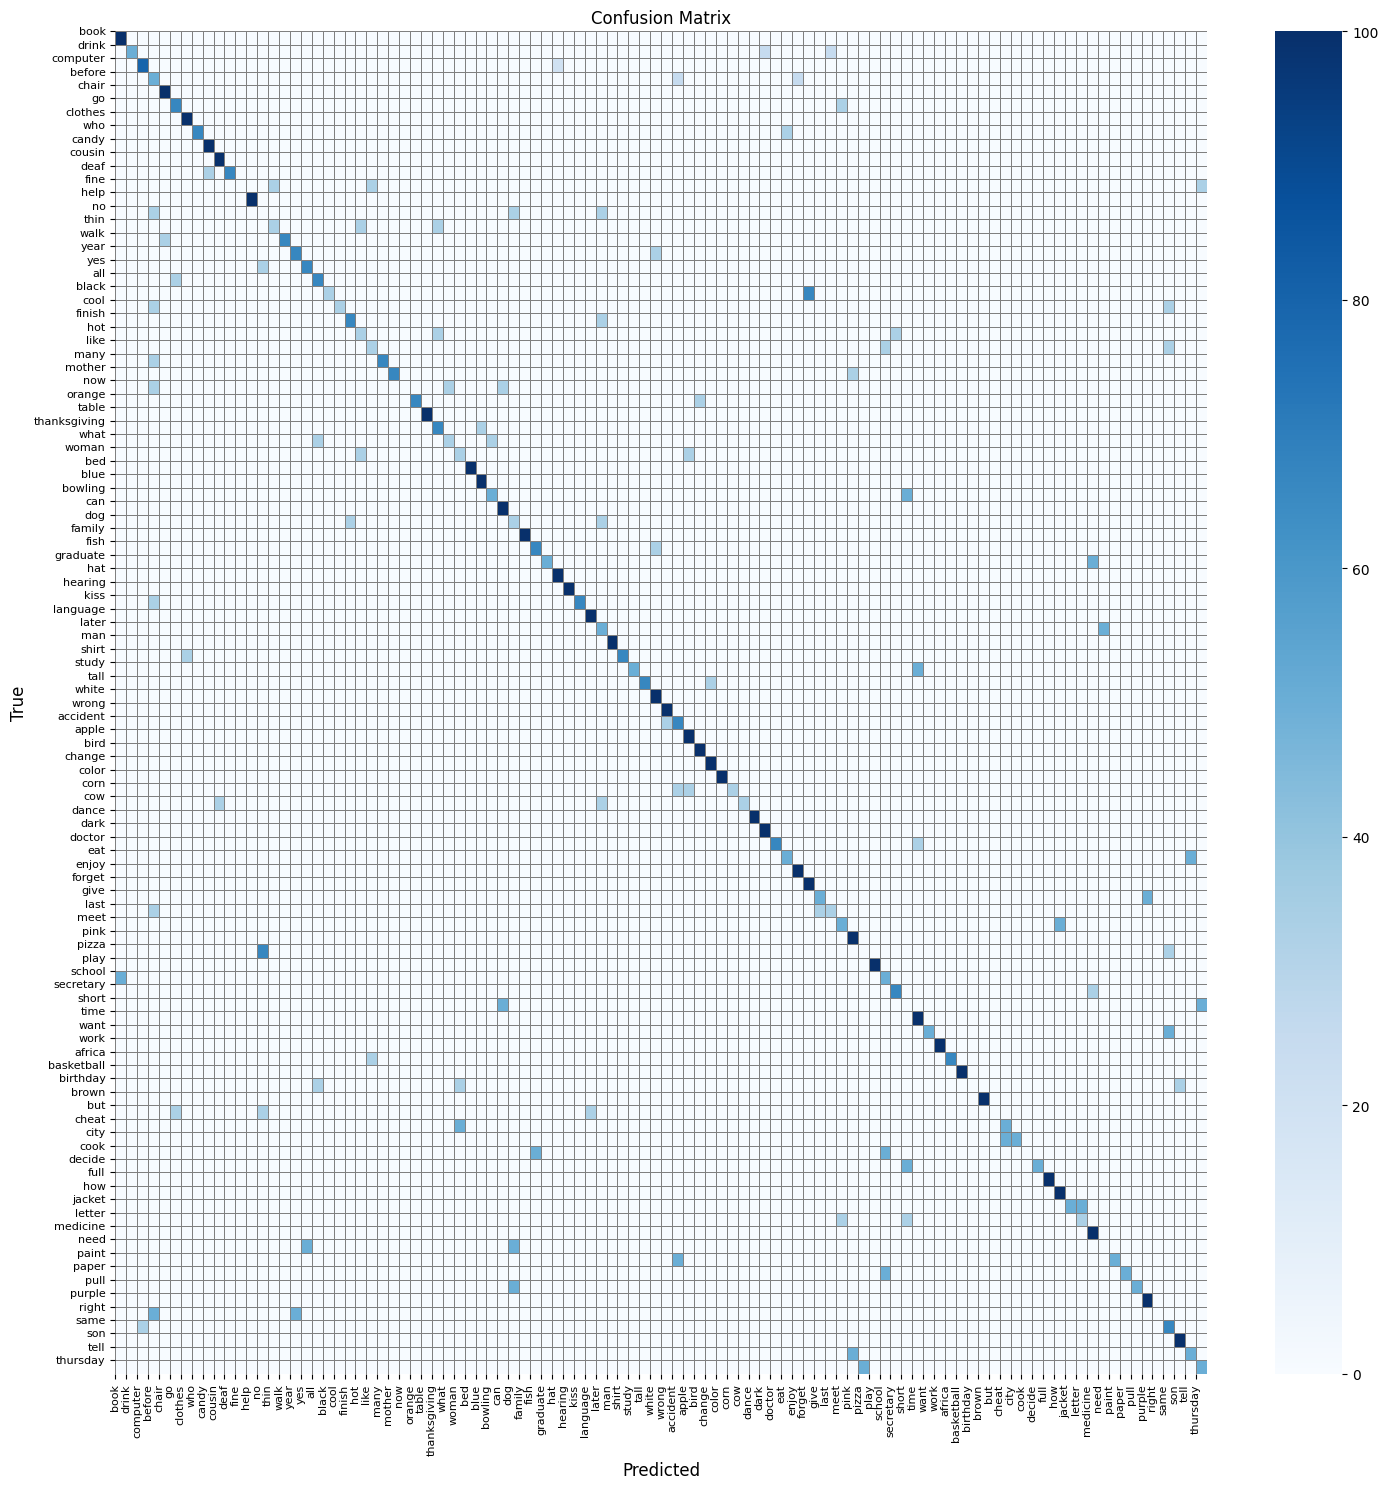

In [38]:
plot_confusion_matrix(all_targets, all_preds, classes_path=classes_path, size=(15, 15))

## Whats weird is that the classes can almost be split into distinct difficulty groups

The model seems to have fully learned some signs, while completely failing to learn others. The rest have stagering degrees of recognition


### Lets see if we can visualise what it sees for the sign 'thursday'


In [ ]:

with open(classes_path, 'r') as f:
  class_list = json.load(f)
print(class_list[99])

thursday


In [ ]:
print(test_set.classes[-10:])

['right', 'same', 'same', 'same', 'son', 'son', 'tell', 'tell', 'thursday', 'thursday']


In [ ]:
print(len(test_set))

258


In [ ]:
item = test_set.data[256]

In [ ]:
def print_dict(dic):
  print("{")
  for key, value in dic.items():
    print(f"'{key}': {value}")
  print("}")  

In [ ]:

frames= test_set.__manual_load__(item)
print_dict(item)

{
'label_num': 99
'frame_end': 46
'frame_start': 1
'video_id': 58359
'bbox': [51, 41, 212, 222]
}


In [ ]:
print(len(frames))
print(type(frames))

32
<class 'torch.Tensor'>


In [ ]:
print(frames.shape)

torch.Size([32, 3, 256, 256])


In [ ]:
utils.watch_video(frames)
# utils.visualise_frames(frames, 32)

### Honestly quite difficult, let's look at another

In [ ]:
item1 = test_set.data[257]
frames1= test_set.__manual_load__(item1)
print_dict(item1)
print(len(frames1))

{
'label_num': 99
'frame_end': 92
'frame_start': 0
'video_id': 70026
'bbox': [61, 30, 199, 235]
}
32


In [ ]:
utils.watch_video(frames1)

In [ ]:
print(item)

{'label_num': 99, 'frame_end': 46, 'frame_start': 1, 'video_id': '58359', 'bbox': [51, 41, 212, 222]}


### Let's gander at the originals

In [ ]:
vid_path = os.path.join(root, f"{item['video_id']}.mp4")
frames_o = utils.load_rgb_frames_from_video(vid_path, item['frame_start'],
                                          item['frame_end'])
print(len(frames_o))
print(vid_path)

45
../data/WLASL2000/58359.mp4


In [ ]:
utils.watch_video(frames_o)

In [ ]:
vid_path1 = os.path.join(root, f"{item1['video_id']}.mp4")
frames_o1 = utils.load_rgb_frames_from_video(vid_path1, item1['frame_start'],
                                          item1['frame_end'])
print(len(frames_o1))
print(vid_path1)

92
../data/WLASL2000/70026.mp4


In [ ]:
utils.watch_video(frames_o1)

### Okay cool they are not being distorted too much through loading, lets see after transforms

In [ ]:
frames_t = test_transforms(frames)
frames_t = frames_t.permute(1,0,2,3) #just reuturn back to T C H W
frames_t = (frames_t * 255).clamp(0, 255).to(torch.uint8)

print(frames_t.dtype)
print(frames_t.shape)

torch.uint8
torch.Size([32, 3, 224, 224])


In [ ]:
utils.watch_video(frames_t)

In [ ]:
frames_t1 = test_transforms(frames1)
frames_t1 = frames_t1.permute(1,0,2,3) #just reuturn back to T C H W
frames_t1 = (frames_t1 * 255).clamp(0, 255).to(torch.uint8)

print(frames_t1.dtype)
print(frames_t1.shape)

torch.uint8
torch.Size([32, 3, 224, 224])


In [ ]:
utils.watch_video(frames_t1)

### Normalising seems to have quite a significant effect on the videos appearence, but stil decernable

## Let's view some samples of this class from the training set

In [ ]:
train_transforms, test_transforms = configs.get_transforms()
  
train_instances = os.path.join(labels, f'train_instances{label_suffix}')
train_classes = os.path.join(labels, f'train_classes{label_suffix}')

In [ ]:
dataset = VideoDataset(root,train_instances, train_classes,
    transforms=train_transforms, num_frames=configs.num_frames)
dataloader = DataLoader(dataset, batch_size=1,
  shuffle=False, num_workers=0,pin_memory=False)
print(len(dataset))
num_classes = len(set(dataset.classes))
print(num_classes)

1442
100


In [ ]:
print(dataset.classes[-13:])

['thursday', 'thursday', 'thursday', 'thursday', 'thursday', 'thursday', 'thursday', 'thursday', 'thursday', 'thursday', 'thursday', 'thursday', 'thursday']


In [ ]:
titems = [dataset.data[i] for i in range(-1, -14, -1)]

for itm in titems:
  print_dict(itm)

{
'label_num': 99
'frame_end': 74
'frame_start': 1
'video_id': 58361
'bbox': [65, 24, 191, 237]
}
{
'label_num': 99
'frame_end': 71
'frame_start': 1
'video_id': 58360
'bbox': [45, 40, 205, 220]
}
{
'label_num': 99
'frame_end': 55
'frame_start': 1
'video_id': 58369
'bbox': [52, 37, 198, 225]
}
{
'label_num': 99
'frame_end': 43
'frame_start': 1
'video_id': 67306
'bbox': [54, 33, 200, 228]
}
{
'label_num': 99
'frame_end': 58
'frame_start': 1
'video_id': 66640
'bbox': [43, 40, 210, 220]
}
{
'label_num': 99
'frame_end': 64
'frame_start': 1
'video_id': 66639
'bbox': [42, 39, 210, 219]
}
{
'label_num': 99
'frame_end': 77
'frame_start': 1
'video_id': 66638
'bbox': [51, 34, 204, 226]
}
{
'label_num': 99
'frame_end': 72
'frame_start': 1
'video_id': 66637
'bbox': [49, 35, 205, 223]
}
{
'label_num': 99
'frame_end': 49
'frame_start': 1
'video_id': 58367
'bbox': [44, 28, 210, 255]
}
{
'label_num': 99
'frame_end': 33
'frame_start': 1
'video_id': 58366
'bbox': [53, 30, 202, 255]
}
{
'label_num': 99
'f

In [ ]:
for itm in titems:
  tframes = dataset.__manual_load__(itm)
  utils.watch_video(tframes)

In [ ]:
#with transforms
for itm in titems:
  tframes = dataset.__manual_load__(itm)
  tframes = test_transforms(tframes)
  tframes = tframes.permute(1,0,2,3) #just reuturn back to T C H W
  tframes = (tframes * 255).clamp(0, 255).to(torch.uint8)
  utils.watch_video(tframes)


In [ ]:
#with training transforms
for i in range(-1, -14, -1):
  item = dataset.__getitem__(i)
  tframes = item['frames']
  tframes = tframes.permute(1,0,2,3) #just reuturn back to T C H W
  tframes = (tframes * 255).clamp(0, 255).to(torch.uint8)
  utils.watch_video(tframes)

### This does at least make me think I should be trying the effect of colour jitter

## Let's see what our model thinks these are

In [ ]:
f = torch.rand(3, 32,224,224)
fa = f.unsqueeze(0)
print(fa.shape)

torch.Size([1, 3, 32, 224, 224])


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
item = test_set.__getitem__(256)
item1 = test_set.__getitem__(257)
frames = item['frames']
frames1 = item1['frames']
frames, frames1 = frames.to(device), frames1.to(device)
out = r3d18(frames.unsqueeze(0))
out1 = r3d18(frames1.unsqueeze(0))



cuda


In [ ]:
import torch.nn.functional as F

# Convert logits to probabilities
probs = F.softmax(out, dim=1)
probs1 = F.softmax(out1, dim=1)

# Get predicted class (highest probability)
pred_class = torch.argmax(out, dim=1)
pred_class1 = torch.argmax(out1, dim=1)

print(f"Item 256 - True class: {item['label_num']}, Predicted: {pred_class.item()}")
print(f"Item 257 - True class: {item1['label_num']}, Predicted: {pred_class1.item()}")

# Get confidence (probability of predicted class)
confidence = torch.max(probs, dim=1)[0]
confidence1 = torch.max(probs1, dim=1)[0]

print(f"Item 256 confidence: {confidence.item():.3f}")
print(f"Item 257 confidence: {confidence1.item():.3f}")

Item 256 - True class: 99, Predicted: 36
Item 257 - True class: 99, Predicted: 68
Item 256 confidence: 0.498
Item 257 confidence: 0.500


In [ ]:
print(class_list[36])
print(class_list[68])

dog
pizza


In [ ]:
dog_idxs = [i for i, x in enumerate(test_set.classes) if x == 'dog']
pizza_idxs = [i for i, x in enumerate(test_set.classes) if x == 'pizza']
print(dog_idxs)
print(pizza_idxs)


[109, 110, 111]
[186, 187, 188]


In [ ]:
titems = [test_set.data[i] for i in dog_idxs + pizza_idxs]
for itm in titems:
  tframes = dataset.__manual_load__(itm)
  utils.watch_video(tframes)

torch.uint8
torch.uint8
torch.uint8
torch.uint8
torch.uint8
torch.uint8


### To be honest, they way some people sign dog and pizza is quite similar to Thursday